# LLM Recall - Needle-in-a-haystack tests

- The Needle-in-a-Haystack test is designed to evaluate the performance of LLM RAG systems across different sizes of context windows. The testing process is straightforward: it asks an LLM to answer a specific question while the correct information ("the needle") is embedded within a large, unrelated context (the haystack).

- This test helps to better understand the retrieval abilities of models with very long context windows (some exceeding 200k tokens). Uniform retrieval performance is not guaranteed, as demonstrated in experiments showing that LLM in-context recall is prompt-dependent (see [LLM In-Context Recall is Prompt Dependent](https://arxiv.org/pdf/2404.08865v1))

- To our knowledge, this experiment has never been conducted on French statistical data.

We will also implement an improvement using multiple facts (needles) to better align with RAG expectations.

We will focus on opensource models (no API) and INSEE-related data. 

In [1]:
! mc cp -q s3/projet-llm-insee-open-data/data/eval_data/eval_retrieval/insee_documents_sample_ref_retrieval_evaluation.csv .

]11;?\mc: Configuration written to `/home/onyxia/.mc/config.json`. Please update your access credentials.
mc: Successfully created `/home/onyxia/.mc/share`.
mc: Initialized share uploads `/home/onyxia/.mc/share/uploads.json` file.
mc: Initialized share downloads `/home/onyxia/.mc/share/downloads.json` file.
`s3/projet-llm-insee-open-data/data/eval_data/eval_retrieval/insee_documents_sample_ref_retrieval_evaluation.csv` -> `insee_documents_sample_ref_retrieval_evaluation.csv`
Total: 4.69 MiB, Transferred: 4.69 MiB, Speed: 12.72 MiB/s


In [ ]:
import pandas as pd 
data = pd.read_csv("./insee_documents_sample_ref_retrieval_evaluation.csv")

In [4]:
data.sample(10)

,content,source,title,insee_id,categories,date_diffusion,themes,collections,libelleAffichageGeo,intertitres,authors,subtitle
2,L'Insee a conçu une base historique des Recens...,https://www.insee.fr/fr/information/1303688,RP Historiques et Données harmonisées des rece...,1303688,Services,2023-04-25T09:00:14.283Z,NaN,NaN,NaN,Description des variables des différents\n ...,[],NaN
26,"À l’instar de l’ébéniste, du forgeron ou du ta...",https://www.insee.fr/fr/information/5008707,Qu’est-ce qu’une donnée ?,5008707,Courrier des statistiques,2020-12-31T09:00:00Z,NaN,NaN,NaN,Les données en statistique La donnée : tentati...,"['Pascal Rivière', 'chef de l’Inspection génér...",Impact des données externes sur la statistique...
70,Les très petites entreprises (TPE) étudiées ic...,https://www.insee.fr/fr/statistiques/4986839,La faiblesse des fonds propres des TPE accroît...,4986839,Publications grand public,2020-12-10T17:00:00Z,['Caractéristiques des entreprises'],Les entreprises en France,France,Les TPE étudiées représentent 38 % des entrepr...,"['Noémie Morénillas', 'Gabriel Sklénard (Insee)']",NaN
6,"À l’école, les filles ont de meilleurs résulta...",https://www.insee.fr/fr/statistiques/6047789,Femmes et Hommes: une lente décrue des inégalités,6047789,Publications grand public,2022-03-03T17:00:00Z,['Égalité femmes-hommes'],Femmes et hommes – L’égalité en question,France,"À l’école, les filles construisent des parcour...",['Philippe\xa0Roussel\xa0(Insee)'],NaN
94,Immigrés et descendants d’immigrés peuvent par...,https://www.insee.fr/fr/statistiques/4175267,Le rôle des origines dans la persistance des i...,4175267,Publications grand public,2019-07-02T16:00:00Z,"['Égalité femmes-hommes', 'Emploi – Population...","Emploi, chômage, revenus du travail",France,"Résumé Pour les immigrés, les caractéristiques...","['Elika Athari', 'Jérôme Lê (Insee)', 'Yaël Br...",NaN
54,Pour nombre d’enquêtes de la statistique publi...,https://www.insee.fr/fr/information/6035936,La mise en musique d’enquêtes multimodes,6035936,Courrier des statistiques,2022-01-20T10:00:00Z,NaN,NaN,NaN,Pour passer d’un seul mode de collecte à plusi...,"['Éric Sigaud', 'maître d’ouvrage délégué du p...",NaN
13,"En France en 2018, 1,9million depersonnes sont...",https://www.insee.fr/fr/statistiques/5371273,Environ 2millions depersonnes en situation de ...,5371273,Publications grand public,2021-05-27T16:00:00Z,['Pauvreté – Précarité'],Les revenus et le patrimoine des ménages,France,"La grande pauvreté, cumul de difficultés monét...","['Julien Blasco', 'Sébastien Picard (Insee)']",NaN
29,"En 2019, la France métropolitaine compte 65mil...",https://www.insee.fr/fr/statistiques/4238437,Quarante ans d’évolution de la démographie fra...,4238437,Publications grand public,2019-11-19T17:00:00Z,['Évolution et structure de la population'],"France, portrait social",International,Un point sur la démographie française depuis 1...,"['Elika Athari', 'Sylvain Papon', 'Isabelle Ro...",NaN
98,La statistique publique produit des chiffres e...,https://www.insee.fr/fr/information/7635829,L’intégration des données administratives dans...,7635829,Courrier des statistiques,2023-06-30T15:00:00Z,NaN,NaN,NaN,La qualification de la source : un pré-requis ...,"['Franck Cotton', 'expert', 'DSI', 'Insee', 'f...",Industrialiser une phase essentielle
69,La Caisse nationale d’assurance vieillesse (Cn...,https://www.insee.fr/fr/information/6665190,Un référentiel des identités pour les besoins ...,6665190,Courrier des statistiques,2022-11-29T13:30:00Z,NaN,NaN,NaN,"Au commencement, connaître les identités pour ...","['Joseph Préveraud de Vaumas', 'Responsable du...",Le système national de gestion des identifiant...


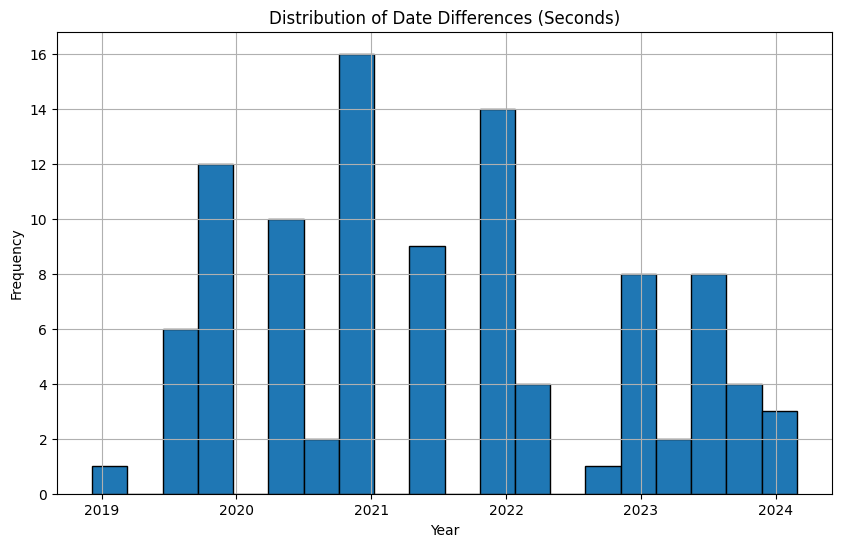

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

# Convert date strings to datetime objects
dates = [parser.isoparse(date_string) for date_string in data["date_diffusion"]]

# Sort the dates to ensure they are in chronological order
dates.sort()

# Plot the distribution of date differences
plt.figure(figsize=(10, 6))
plt.hist(dates, bins=20, edgecolor='black')
plt.title('Distribution of Date Differences (Seconds)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [2]:
INSTRUCTION_TEMPLATE  = """
Réponds à la question donnée en basant ta réponse uniquement sur les informations fournises en context. 

Context:
{context}

Question:
{question}

Réponse:
"""

INSTRUCTION_EVAL = """
Tu es un assistant IA spécialisé en Statistique Publique.
Veuillez agir en tant que juge impartial et évaluer la qualité de la réponse fournie par un assistant IA à la question de l'utilisateur affichée ci-dessous. 
Pour cette évaluation, vous devez principalement considérer le critère suivant:

Précision:
    Note 1 : La réponse n’a aucun rapport avec la référence.
    Note 2 : La réponse a une pertinence mineure mais ne correspond pas à la référence.
    Note 3 : La réponse est moyennement pertinente mais contient des inexactitudes.
    Note 4 : La réponse correspond à la référence mais comporte des omissions mineures.
    Note 5 : La réponse est tout à fait exacte et correspond parfaitement à la référence.


Commencez votre évaluation en fournissant une brève explication. Soyez le plus objectif possible. 
Après avoir fourni votre explication, vous devez évaluer la réponse sur une échelle de 1 à 5.
Vous répondrez en FRANCAIS en respectant OBLIGATOIREMENT le format de réponse suivant : {{"explanation" : explication, "score": score}}

Par exemple vous pourrez renvoyer:

Votre réponse : 
{{"explanation" : "La réponse donnnée ne correspond absolument pas à la réponse de référence", "score": 1}}

--- 

Voic la réponse de référence : 
{ground_truth_answer}

Voici la question posée : 
{question}

Voici la réponse générée :
{generated_answer}

Votre réponse : 
"""

### Needle in Haystack class

The task we can ask : 
- ask a figure : Quel est le taux de chômage de la population française au premier trimestre 2024 ? 
    Answer : 7.5
- Give a definition : Quel est la définition du coût salariale ? 
    Answer : Le coût salarial est constitué par l'ensemble des dépenses qui incombent à l'employeur pour l'emploi d'un salarié. Il se répartit en :
    un coût direct, composé principalement des salaires bruts et différents avantages salariaux ;
    un coût indirect formé essentiellement des cotisations patronales légales et conventionnelles et de diverses charges.
    Dans le coût direct, les avantages salariaux correspondent notamment aux avantages en nature, à l'intéressement et à la participation.
    Dans le coût indirect les charges autres que les cotisations patronales correspondent notamment à la formation professionnelle, aux frais de transport et aux œuvres sociales.
- ask to retrieve multiple figures ? 
    Donne moi le taux d'inflation, le taux de croissance et le taux de chômage au premier trimestre 2024.
    Answer : 
        - taux d'inflation : +2.2%
        - taux de croissance : 0.2%
        - taux de chômage : 7.5%

- A combien estime t on le nombre de logement supplémentaire par an entre 2024 et 2029 ? 
    Answer : 
    L’évaluation des besoins en logements dans la région des Pays de la Loire témoigne d’une dynamique soutenue, reflétant les enjeux démographiques et économiques de la région. Les besoins sont estimés à 23 700 logements par an entre 2024 et 2029.
- Qu'est ce que l'inflation ? 
    answer : L'inflation est la perte du pouvoir d'achat de la monnaie qui se traduit par une augmentation générale et durable des prix. 
- Comment est calculé l'inflation ? 
    answer : L’indice des prix à la consommation (IPC) est utilisé pour évaluer l’inflation.
- Comment s'appelle le jeu de données sur les échanges extérieurs de la France ? 
    Answer : DD_CNA_ECH_EXT


In [87]:
from typing import List, Dict, Tuple
import re
import os
import json
import ast
from tqdm import tqdm 
import torch
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

from transformers import (AutoConfig,
                          AutoTokenizer,
                          AutoModelForCausalLM,
                          pipeline, BitsAndBytesConfig
                          )

import logging 
logger = logging.getLogger(__name__)

class Evaluator:
    """
    Class to set up and run LLM-as-a-judge Needle-in-HayStack evaluation
    """

    def __init__(self, tokenizer=None, model=None,question="" ,gt_answer="", prompt_eval = INSTRUCTION_EVAL, 
        kwargs={"max_new_tokens": 250,"return_full_text": False,"do_sample": False}, verbose=False):
        
        self.tokenizer = tokenizer
        self.model = model
        self.question_asked = question
        self.gt_answer = gt_answer
        self.pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer)
        self.prompt_template_eval = prompt_eval
        self.kwargs = kwargs
        self.verbose = verbose 

    def build_final_prompt(self, ground_truth_answer, generated_answer):
        """
        Build evaluation prompt
        """
        complete_prompt = self.prompt_template_eval.format(
            question=self.question_asked,
            ground_truth_answer=ground_truth_answer,
            generated_answer=generated_answer
        )
        instructions = [
            {"role": "assistant", "content": "Tu es un assistant spécialisé en statistique publique"},
            {"role": "user", "content": complete_prompt}
        ]
        return self.tokenizer.apply_chat_template(instructions, tokenize=False)


    def evaluation_parser(
            self, evaluation: str):
        '''
        parsing generated evaluation to extract score and explanation
        '''

        # Define a regular expression pattern to match a dictionary string
        pattern = r'\{.*?\}'

        # Find all matches in the string
        matches = re.findall(pattern, evaluation)

        dictionaries = []
        for match in matches:
            try:
                # Safely evaluate the string to a dictionary
                dictionaries.append(ast.literal_eval(match))
            except (SyntaxError, ValueError):
                if self.verbose:
                    logger.error("Error at parsing Evaluation, return default value")
                    logger.info("evaluation reveived : ", evaluation)
                return {"explanation" : None , "score" : None}  # If the match is not a valid dictionary, skip it

        if len(dictionaries) > 0: 
            d = dictionaries[0]
            return {"explanation" : d["explanation"], "score" : int(d["score"])}
        else :
            return {"explanation" : None , "score" : None} 


    def evaluate(self, generated_answers: List[str]) -> List[str]:
        """
        run in batch evaluation
        """
        final_prompt = [
            self.build_final_prompt(ground_truth_answer=self.gt_answer, generated_answer=ans) for ans in generated_answers
            ]
        evaluations = self.pipe(final_prompt, **self.kwargs)

        return [self.evaluation_parser(eval_[0]["generated_text"]) for eval_ in evaluations]

class LLMNeedleHaystackTester:
    '''
        Class to set up Needle in the haystack test ,
        implementation inspired by https://github.com/Arize-ai/LLMTest_NeedleInAHaystack2 and https://github.com/gkamradt/LLMTest_NeedleInAHaystack
    '''

    def __init__(
        self,
        needle="",
        retrieval_question="",
        results_version=1,
        context_lengths_min=50,
        context_lengths_max=1000,
        context_lengths_num_intervals=10,
        context_lengths=None,
        document_depth_percent_min=0,
        document_depth_percent_max=100,
        document_depth_percent_intervals=35,
        document_depth_percents=None,
        llm_name="mistralai/Mistral-7B-Instruct-v0.2",
        evaluation=False,
        prompt_template="",
        corpus_file="./insee_documents_sample_ref_retrieval_evaluation.csv",
        save_results=False,
        final_context_length_buffer=200,
        kwargs={
            "max_new_tokens": 50,
            "temperature": 0.2,
            "return_full_text": False,
            "do_sample": True},
        verbose = False
        ):

        self.needle = needle
        if not needle or not retrieval_question:
            raise ValueError("Needle and retrieval_question must be provided.")

        self.context_lengths_num_intervals = context_lengths_num_intervals
        self.document_depth_percent_intervals = document_depth_percent_intervals
        self.retrieval_question = retrieval_question
        self.results_version = results_version
        self.save_results = save_results
        self.corpus_file = corpus_file
        self.verbose = verbose 

        # load llm and its tokenizer for generation
        if llm_name is not None:
            self.llm_name = llm_name
            self.model, self.tokenizer = self.load_llm_model(
                llm_name, to_load=["tokenizer", "model"], quantization=True)
            self.pipe = pipeline(
                task="text-generation",
                model=self.model,
                tokenizer=self.tokenizer)
        else:
            raise "Error No LLM model loaded"

        self.kwargs = kwargs
        self.prompt_template = prompt_template
        self.final_context_length_buffer = self.estimate_final_context_length_buffer()
        self.evaluator = None


        if evaluation:
            model_name_eval = "microsoft/Phi-3-mini-128k-instruct"
            eval_model, eval_tokenizer = self.load_llm_model(
                model_name_eval, to_load=["tokenizer", "model"], quantization=True)
            self.evaluator = Evaluator(
                tokenizer=eval_tokenizer,
                model=eval_model,
                question=self.retrieval_question,
                gt_answer=self.needle,
                prompt_eval=INSTRUCTION_EVAL,
                verbose = self.verbose
            )

        if context_lengths is None:
            if context_lengths_min is None or context_lengths_max is None or context_lengths_num_intervals is None:
                raise ValueError(
                    "Either context_lengths_min, context_lengths_max, context_lengths_intervals need to be filled out OR the context_lengths_list needs to be supplied.")
            else:
                context_lengths = np.round(np.linspace(context_lengths_min, context_lengths_max,num=context_lengths_num_intervals, endpoint=True)).astype(int)
                self.context_lengths = [int(x) for x in context_lengths]
        else:
            self.context_lengths = [int(x) for x in context_lengths]

        if document_depth_percents is None:
            if document_depth_percent_min is None or document_depth_percent_max is None or document_depth_percent_intervals is None:
                raise ValueError(
                    "Either document_depth_percent_min, document_depth_percent_max, document_depth_percent_intervals need to be filled out OR the document_depth_percents needs to be supplied.")
            else:
                document_depth_percents = np.round(
                    np.linspace(
                        document_depth_percent_min,
                        document_depth_percent_max,
                        num=document_depth_percent_intervals,
                        endpoint=True)).astype(int)
                self.document_depth_percents = [int(x) for x in document_depth_percents]
        else:
            self.document_depth_percents = [int(x) for x in document_depth_percents]

    def load_llm_model(
            self,
            model_name,
            to_load=[
                "tokenizer",
                "model"],
            quantization=True) -> Tuple:

        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(
            pretrained_model_name_or_path=model_name,
            use_fast=True,
            device_map="auto")

        # Check if tokenizer has a pad_token; if not, set it to eos_token
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        if "model" not in to_load:
            return _, tokenizer

        # Load LLM config
        config = AutoConfig.from_pretrained(
            pretrained_model_name_or_path=model_name,
            trust_remote_code=True)

        if quantization:
            # Load quantization config
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype="float16",
                bnb_4bit_use_double_quant=False,
            )

        # Load LLM
        model = AutoModelForCausalLM.from_pretrained(
            pretrained_model_name_or_path=model_name,
            config=config,
            quantization_config=quantization_config if quantization else None,
            device_map="cuda" if torch.cuda.is_available() else "cpu",
            torch_dtype="auto",
            trust_remote_code=True,
        )
        return model, tokenizer

    def load_corpus(self, nb_sample=2) -> str:
        if os.path.exists(self.corpus_file):
            ext = self.corpus_file.split(".")[-1]
            if ext == "json":
                df = pd.read_json(self.corpus_file)
            elif ext == "csv":
                df = pd.read_csv(self.corpus_file)
            else:
                raise ValueError("File extension is not recognized")

            return ' '.join(df.sample(nb_sample)["content"].astype(str))
        else:
            raise FileNotFoundError("The provided file path does not exist")

    def build_final_prompt(self, question, context):
        complete_prompt = self.prompt_template.format(
            context=context, question=question)
        instructions = [
            {"role": "user", "content": complete_prompt}
        ]
        return self.tokenizer.apply_chat_template(instructions, tokenize=False)

    def estimate_final_context_length_buffer(self) -> int:
        length_token_question = len(
            self.encode_text_to_tokens(
                self.retrieval_question))
        length_token_prompt = len(
            self.encode_text_to_tokens(
                self.prompt_template))
        length_token_generation = self.kwargs.get("max_new_tokens", 50)
        return length_token_question + length_token_prompt + length_token_generation + 10

    def result_exists(self, context_length: int, depth_percent: int) -> bool:
        results_dir = 'results/' + str(self.results_version) + "/"
        if not os.path.exists(results_dir):
            return False

        for filename in os.listdir(results_dir):
            if filename.endswith('.json'):
                file_path = os.path.join(results_dir, filename)
                try:
                    with open(file_path, 'r') as f:
                        try:
                            result = json.load(f)
                        except json.JSONDecodeError as e:
                            print(f"Error decoding JSON from file {file_path}: {e}")
                            continue

                        context_length_met = (result['context_length'] == context_length)
                        depth_percent_met = (result['depth_percent'] == depth_percent)
                        version_met = (result.get('version', 1) == self.results_version)
                        model_met = (result['model'] == self.llm_name)

                        if context_length_met and depth_percent_met and version_met and model_met:
                            return True

                except IOError as e:
                    logger.error(f"Error reading file {file_path}: {e}")
                    continue
        return False

    def encode_text_to_tokens(self, text: str) -> List[int]:
        return self.tokenizer.encode(text)

    def decode_tokens(
            self,
            tokens: List[int],
            context_length: int = None) -> str:
        return self.tokenizer.decode(tokens[:context_length])

    def encode_and_trim(self, context: str, context_length: int) -> str:
        tokens = self.encode_text_to_tokens(context)
        if len(tokens) > context_length:
            context = self.decode_tokens(tokens, context_length)
        return context

    def insert_needle(
            self,
            needle: str,
            context: str,
            depth_percent: int,
            context_length: int) -> str:
        tokens_needle = self.encode_text_to_tokens(needle)
        tokens_context = self.encode_text_to_tokens(context)
        context_length -= self.final_context_length_buffer

        if len(tokens_context) + len(tokens_needle) > context_length:
            tokens_context = tokens_context[:context_length -
                                            len(tokens_needle)]

        tokens_new_context = [42]  # initialize

        if depth_percent == 100:
            tokens_new_context = tokens_context + tokens_needle  # add element at the end
        else:
            insertion_point = int(len(tokens_context) * (depth_percent / 100))
            period_tokens = self.encode_text_to_tokens(
                '.')  # encode point character
            while tokens_new_context and (
                    tokens_new_context[-1] not in period_tokens):
                insertion_point -= 1
                tokens_new_context = tokens_context[:insertion_point]

            tokens_new_context += tokens_needle + \
                tokens_context[insertion_point:]

        new_context = self.decode_tokens(tokens_new_context)
        return new_context

    def generate_context(
            self,
            needle: str,
            trim_context: str,
            context_length: int,
            depth_percent: int) -> str:
        """_summary_

        Args:
            needle (str): _description_
            trim_context (str): _description_
            context_length (int): _description_
            depth_percent (int): _description_

        Returns:
            str: _description_
        """
        return self.insert_needle(
            needle=needle,
            context=trim_context,
            depth_percent=depth_percent,
            context_length=context_length
        )

    def aggregate(self, results) -> Dict:
        scores = [int(r['score']) for r in results]
        return {
            "scores": scores,
            "median": np.median(scores),
            "mean": np.mean(scores),
            "std_dev": np.std(scores),
            "count": len(scores)
        }

    def save(
            self,
            result,
            context_length,
            depth_percent,
            gt_answer,
            corpus_sample,
            explanation=None) -> None:
        """_summary_

        Args:
            result (_type_): _description_
            context_length (_type_): _description_
            depth_percent (_type_): _description_
            gt_answer (_type_): _description_
            corpus_sample (_type_): _description_
            explanation (_type_, optional): _description_. Defaults to None.
        """
        #timestamp = time.strftime("%Y%m%d-%H%M%S")
        results_dir = 'results/' + str(self.results_version) + "/"
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        results_dict = {
            'model': self.llm_name,
            'needle': gt_answer,
            'context_length': context_length,
            'depth_percent': depth_percent,
            'result': result,
            'prompt_template': self.prompt_template,
            'corpus': str(corpus_sample),
            'version': self.results_version
        }
        if explanation:
            results_dict['explanations'] = explanation

        #build file name 
        filename = f'results_{self.llm_name.split("/")[-1]}_{context_length}_{depth_percent}.json'
        #turn a dictionary into a json object

        with open(os.path.join(results_dir, filename), 'w') as f:
            json.dump(results_dict, f)

    def run(self, nb_corpus_sample=2):
        """_summary_

        Args:
            nb_corpus_sample (int, optional): _description_. Defaults to 2.

        Returns:
            _type_: _description_
        """
        corpus_sample = self.load_corpus(nb_corpus_sample)

        print(f"{self.llm_name} tokenizes the corpus in {len(self.encode_text_to_tokens(corpus_sample))} tokens")

        all_results = {}

        list_context_depth_tuples = []
        list_final_prompts = []
        generated_contexts = []
        for context_length in self.context_lengths:
            for depth_percent in self.document_depth_percents:

                if not self.result_exists(context_length, depth_percent):
                    # add only the non-already tested tuples
                    list_context_depth_tuples.append(
                        (context_length, depth_percent))
                    trimmed_context = self.encode_and_trim(corpus_sample, context_length)
                    generated_context = self.generate_context(self.needle, trimmed_context, context_length, depth_percent)
                    generated_contexts.append(generated_context)
                    final_prompt = self.build_final_prompt(self.retrieval_question, generated_context)
                    list_final_prompts.append(final_prompt)

        if len(list_context_depth_tuples) != 0:

            print(
                f"\nThe following {len(list_context_depth_tuples)} context_lenght & depth percentages will be tested : ",
                list_context_depth_tuples
                )
            # run pipeline
            answers = self.pipe(list_final_prompts, **self.kwargs)
            generated_answers = [str(ans[0]["generated_text"]) for ans in answers]

            #print("generated answer : \n-", "\n-".join(generated_answers))

            if self.evaluator:
                evaluation_results = self.evaluator.evaluate(generated_answers)
                #print("evaluation : " , evaluation_results)
                # extract explanations
                for i, (context_length, depth_percent) in enumerate(list_context_depth_tuples):
                    eval_res = evaluation_results[i]
                    score = int(eval_res["score"]) if eval_res["score"] is not None else 0
                    exp = str(eval_res["explanation"]) if eval_res["explanation"] is not None else "No explanation available"
                    all_results[(context_length, depth_percent)] = {"score" : score, "explanation" : exp} # keep the score

                    if self.save_results :
                        self.save(result=score,
                                context_length=context_length,
                                depth_percent=depth_percent,
                                gt_answer=self.needle,
                                corpus_sample=generated_contexts[i], #add the context where the needle have been added
                                explanation=exp)
            else:
                for i, (context_length, depth_percent) in enumerate(list_context_depth_tuples):
                    all_results[(context_length, depth_percent)] = generated_answers[i]

                    if self.save_results: 
                        self.save(
                            result=generated_answers[i],
                            context_length=context_length,
                            depth_percent=depth_percent,
                            gt_answer=self.needle,
                            corpus_sample=generated_contexts[i] #add the context where the needle have been added
                            )
        else:
            print("Skipping this configuration as result already exists")

        return all_results

    def load_results(self, results_dir="./results", model_name = "mistralai/Mistral-7B-Instruct-v0.2", version=1):
        """
        load the results from a previous experiment based on  
        """
        results = {}
        results_dir += "/" + str(version)

        if not os.path.exists(results_dir):
            return None 
        else: 
            
            list_docs = os.listdir(results_dir)
            print(f"{len(list_docs)} documents have been found")

            for filename in tqdm(list_docs):
                if filename.endswith('.json'):
                    file_path = os.path.join(results_dir, filename)
                    try:
                        with open(file_path, 'r') as f:
                            try:
                                r = json.load(f)
                            except json.JSONDecodeError as e:
                                print(f"Error decoding JSON from file {file_path}: {e}")
                                continue
                            
                            if "result" in r and "explanations" in r and "model" in r and "version" in r: 
                                if r["model"] == model_name and r["version"] ==  version: 
                                    results[(r['context_length'], r['depth_percent'])] = {"score" : r["result"], "explanation" : r["explanations"]}

                    except IOError as e:
                        logger.error(f"Error reading file {file_path}: {e}")
                        continue
        
        return results

    def plot(
            self,
            results: Dict,
            title= None,
            filename=None):

        if title is None:
            title = str(self.llm_name) + " Recall Performance" 

        if filename is None:
            filename = str(self.llm_name).split("/")[-1] + "_recall_performances.png"

        depth_percents = sorted(set(k[1] for k in results.keys()))
        context_lengths = sorted(set(k[0] for k in results.keys()))
        scores = np.full((len(depth_percents), len(context_lengths)), np.nan)

        for (context_length, depth_percent), dict_res in results.items():
            i = depth_percents.index(depth_percent)
            j = context_lengths.index(context_length)
            scores[i, j] = int(dict_res["score"])

        #change nan value by 0
        scores[np.isnan(scores)] = 0
        recall_score = np.round(np.sum(scores) / (5 * len(depth_percents) * len(context_lengths)), 3) * 100

        fig, ax = plt.subplots(figsize=(10, 10))
        cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
        cax = ax.matshow(
            scores,
            cmap=cmap,
            norm=Normalize(vmin=0,vmax=5)
            )

        plt.colorbar(cax, fraction=0.046, pad=0.04)
        plt.yticks(range(len(depth_percents)), depth_percents)
        plt.xticks(range(len(context_lengths)), context_lengths, rotation=45)
        plt.ylabel("Fact Placement Depth (%)")
        plt.xlabel("Haystack Size")

        plt.title(f"{title} (Recall Score : {str(recall_score)}%)\n {self.retrieval_question}", fontsize = 12)

        plt.savefig(filename)
        plt.show()

def generate_image(self, results: Dict, color_palette='viridis', title=None):
        # If title is None, set a default title
        if title is None:
            title = str(self.llm_name) + " Recall Performance" 

        # Extract and sort unique context lengths and depth percents
        depth_percents = sorted(set(k[1] for k in results.keys()))
        context_lengths = sorted(set(k[0] for k in results.keys()))

        # Create a DataFrame to hold the results
        data = pd.DataFrame(index=depth_percents, columns=context_lengths)
    
        # Populate the DataFrame with results
        for (context_length, depth_percent), res in results.items():
            data.loc[depth_percent, context_length] = int(res["score"])

        #remove the nan values to get a complete heatmap 
        data.fillna(0, inplace=True)

        recall_score = np.round(data.sum().sum() / (5* len(depth_percents) * len(context_lengths)),3) *100

        # Create the figure and axis for the heatmap
        fig, ax = plt.subplots(figsize=(15, 10))

        cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])
        
        # Generate the heatmap
        sns.heatmap(
            data, 
            #annot=True, 
            fmt= "g", #".2f", 
            xticklabels="auto",  
            yticklabels="auto",  
            cmap=cmap, 
            cbar=True, 
            cbar_kws={'label': 'score'}, 
            vmin=0, 
            vmax=5, 
            linewidths=.5, 
            linecolor='black', 
            ax=ax
        )

        # Set axis labels and title
        ax.set_xlabel('Haystack Size')
        ax.set_ylabel("Fact Placement Depth (%)")
        ax.set_title(f"{title} (Recall Score : {recall_score}%)\n {self.retrieval_question}", fontsize = 12)
        plt.xticks(rotation=45)

        # Save the figure to the specified file path
        file_name = str(self.llm_name).split("/")[-1] + "_recall_performances.png"

        plt.savefig(file_name)
       
        # Display the plot (optional)
        plt.show()

#some experiments have already been evaluated for Mistral-7B-Instruct-v0.1 and Mistral-7B-Instruct-v0.2, meta-llama/Meta-Llama-3-8B-Instruct
#Questions already asked : 
#question about unemployement 
#question about inflation defintion? 

### Test 

In [88]:
llm_name = "mistralai/Mistral-7B-Instruct-v0.2" #context length : 32000
#llm_name = "meta-llama/Meta-Llama-3-8B-Instruct" # context length : 8000

question = "Qu'est ce que l'inflation ?"
needle =  "L'inflation est la perte du pouvoir d'achat de la monnaie qui se traduit par une augmentation générale et durable des prix."

llm_tester = LLMNeedleHaystackTester(
        needle=needle,
        retrieval_question=question,
        results_version=3,
        context_lengths_min=100,
        context_lengths_max=32000,
        context_lengths_num_intervals=10,
        context_lengths= None ,
        document_depth_percent_min=0,
        document_depth_percent_max=100,
        document_depth_percent_intervals=10,
        document_depth_percents=None,
        llm_name=llm_name,
        evaluation=True,
        prompt_template=INSTRUCTION_TEMPLATE,
        corpus_file="./insee_documents_sample_ref_retrieval_evaluation.csv",
        save_results=True,
        final_context_length_buffer=200,
        verbose = True 
    )

/opt/mamba/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [89]:
#run the experiment 
results = llm_tester.run(nb_corpus_sample=4)

mistralai/Mistral-7B-Instruct-v0.2 tokenizes the corpus in 49078 tokens



The following 100 context_lenght & depth percentages will be tested :  [(100, 0), (100, 11), (100, 22), (100, 33), (100, 44), (100, 56), (100, 67), (100, 78), (100, 89), (100, 100), (3644, 0), (3644, 11), (3644, 22), (3644, 33), (3644, 44), (3644, 56), (3644, 67), (3644, 78), (3644, 89), (3644, 100), (7189, 0), (7189, 11), (7189, 22), (7189, 33), (7189, 44), (7189, 56), (7189, 67), (7189, 78), (7189, 89), (7189, 100), (10733, 0), (10733, 11), (10733, 22), (10733, 33), (10733, 44), (10733, 56), (10733, 67), (10733, 78), (10733, 89), (10733, 100), (14278, 0), (14278, 11), (14278, 22), (14278, 33), (14278, 44), (14278, 56), (14278, 67), (14278, 78), (14278, 89), (14278, 100), (17822, 0), (17822, 11), (17822, 22), (17822, 33), (17822, 44), (17822, 56), (17822, 67), (17822, 78), (17822, 89), (17822, 100), (21367, 0), (21367, 11), (21367, 22), (21367, 33), (21367, 44), (21367, 56), (21367, 67), (21367, 78), (21367, 89), (21367, 100), (24911, 0), (24911, 11), (24911, 22), (24911, 33), (24911

Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value
Error at parsing Evaluation, return default value


In [93]:
res = llm_tester.load_results(lresults_dir="./results", model_name = "mistralai/Mistral-7B-Instruct-v0.2", version=3)

TypeError: LLMNeedleHaystackTester.load_results() got an unexpected keyword argument 'lresults_dir'

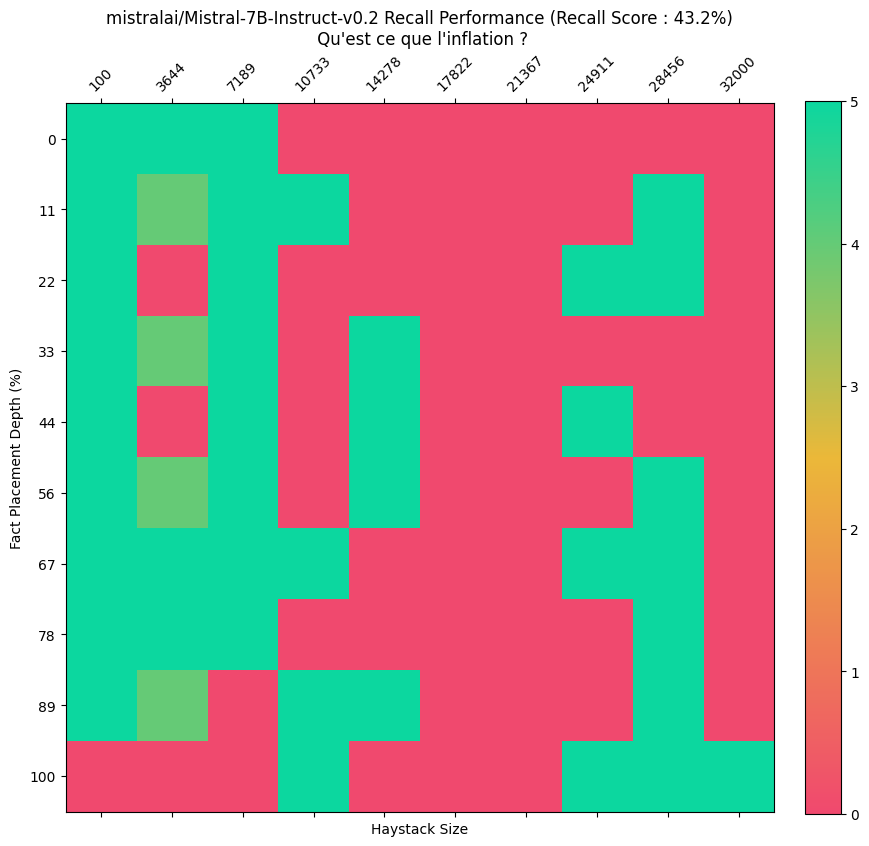

In [ ]:
llm_tester.plot(results=res)

271 documents have been found


100%|██████████| 271/271 [00:00<00:00, 5140.31it/s]


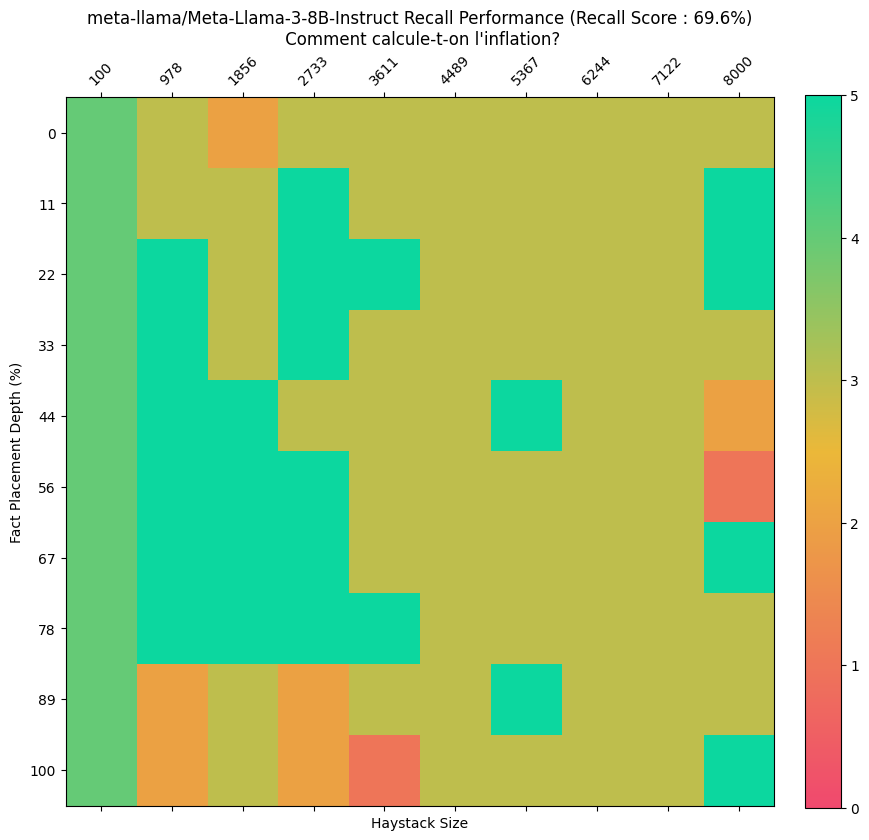

In [77]:
res = llm_tester.load_results(results_dir="./results", model_name = "meta-llama/Meta-Llama-3-8B-Instruct", version=2)
llm_tester.plot(results=res)

271 documents have been found


100%|██████████| 271/271 [00:00<00:00, 5327.49it/s]


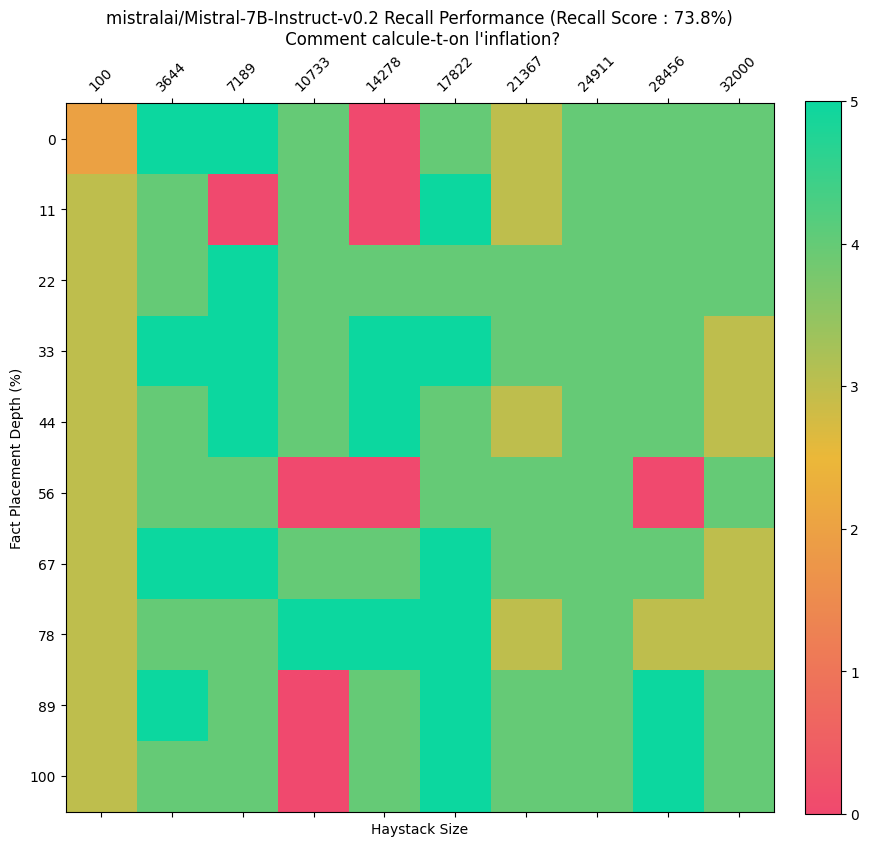

In [80]:
res = llm_tester.load_results(results_dir="./results", model_name = "mistralai/Mistral-7B-Instruct-v0.2", version=2)
llm_tester.plot(results=res)